# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 5.47 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [ ]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/9/95/191215_TVN_%EC%A6%90%EA%B1%B0%EC%9B%80%EC%A0%84_%ED%98%B8%ED%85%94%EB%8D%B8%EB%A3%A8%EB%82%98_%ED%86%A0%ED%81%AC%EC%84%B8%EC%85%98_%EC%95%84%EC%9D%B4%EC%9C%A0_%286%29.jpg -O raw/iu_01.jpg
!wget https://image.bugsm.co.kr/artist/images/1000/800491/80049126.jpg -O raw/iu_02.jpg

--2021-09-15 06:57:40--  https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332712 (325K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 324.91K  --.-KB/s    in 0.07s   

2021-09-15 06:57:41 (4.50 MB/s) - ‘raw/example.jpg’ saved [332712/332712]

--2021-09-15 06:57:41--  https://upload.wikimedia.org/wikipedia/commons/9/95/191215_TVN_%EC%A6%90%EA%B1%B0%EC%9B%80%EC%A0%84_%ED%98%B8%ED%85%94%EB%8D%B8%EB%A3%A8%EB%82%98_%ED%86%A0%ED%81%AC%EC%84%B8%EC%85%98_%EC%95%84%EC%9D%B4%EC%9C%A0_%286%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP reque

# Load Pretrained Models

In [ ]:
import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


# Align Faces

In [ ]:
!python align_images.py raw aligned

# Extract Latent Vector from Aligned Face

In [ ]:
!python project_images.py --num-steps 1000 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "hailee2_01.png"...
0 / 1000 ... 2021-09-15 07:13:21.429561: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_G

# Get Result from Blended Model

In [ ]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


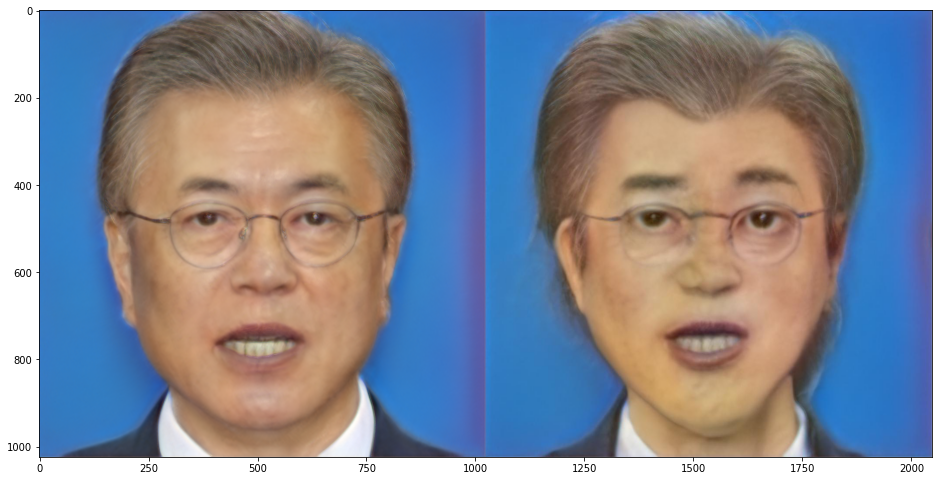

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

embedded = Image.open("generated/moon_01.png")
tooned = Image.open("generated/moon_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))

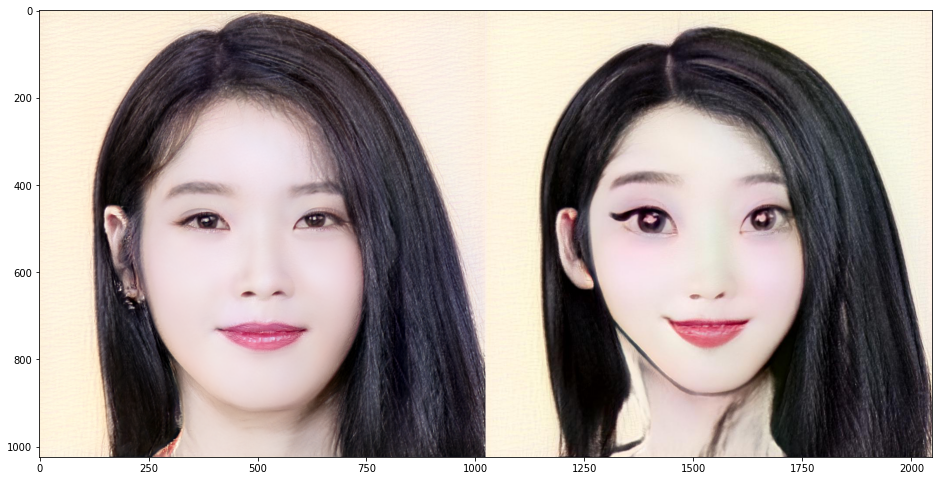

In [ ]:
embedded = Image.open("generated/iu_01_01.png")
tooned = Image.open("generated/iu_01_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))

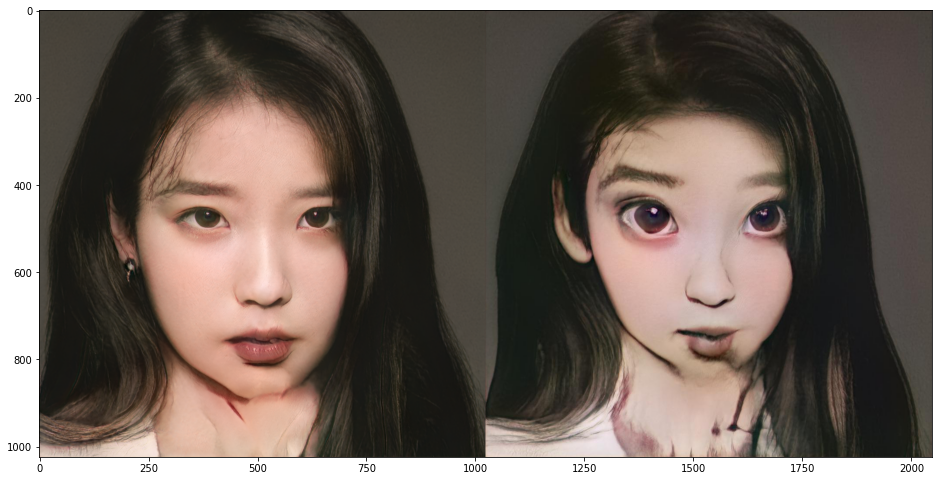

In [ ]:
embedded = Image.open("generated/iu_02_01.png")
tooned = Image.open("generated/iu_02_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))